## License plate detection + OCR (YOLO + PaddleOCR)

This notebook is a cell-based version of `license_plate_detection_with_ocr.py`.

### Files
- `image_path`: input image
- `model_path`: your trained Ultralytics YOLO `.pt` model

### Install
Run in a terminal:

```bash
pip install -r requirements.txt
```

> Note: `ultralytics` uses PyTorch. If `torch` isn’t installed automatically for your setup (CPU/GPU), install it separately following PyTorch’s official instructions.



In [90]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from paddleocr import PaddleOCR
from ultralytics import YOLO

# --- 1. Setup ---
# Initialize PaddleOCR (downloads model automatically on first run)
# lang='en' covers english alphanumeric characters (standard for plates)
# Użyj modelu "server" zamiast "mobile" - wolniejszy ale dokładniejszy
# det_model_name - model detekcji tekstu
# rec_model_name - model rozpoznawania tekstu (to jest kluczowe!)
ocr = PaddleOCR(
    lang="en",
    ocr_version="PP-OCRv4",
    text_detection_model_name="PP-OCRv4_server_det",
    text_recognition_model_name="PP-OCRv4_server_rec",
    use_doc_orientation_classify=False,
    use_doc_unwarping=False,
    use_textline_orientation=True,  # odpowiednik "angle/cls" w nowym pipeline
)

root = Path.cwd()
image_path = root / "60f9939b5c55b_o_xlarge.jpg"
model_path = root / "license-plate-finetune-v1n.pt"

assert image_path.exists(), f"Missing image: {image_path}"
assert model_path.exists(), f"Missing model: {model_path}"

# Load your custom YOLO model
model = YOLO(model_path)

print("image_path:", image_path)
print("model_path:", model_path)

/tmp/ipykernel_49129/2627763424.py:15: UserWarning: `lang` and `ocr_version` will be ignored when model names or model directories are not `None`.
  ocr = PaddleOCR(
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/petitoff/.paddlex/official_models/PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv4_server_det', None)
Using official model (PP-OCRv4_server_det), the model files will be automatically downloaded and saved in `/home/petitoff/.paddlex/official_models/PP-OCRv4_server_det`.
Fetching 6 files: 100%|██████████| 6/6 [00:13<00:00,  2.24s/it]
Creating model: ('PP-OCRv4_server_rec', None)
Using official model (PP-OCRv4_server_rec), the model files will be automatically downloaded and saved in `/home/petitoff/.paddlex/official_models/PP-OCRv4_server_rec`.
Fetching 6 files: 100%|██████████| 6/6 [00:12<00:00,  2.05s/it]


image_path: /home/petitoff/repos/license_plate_ocr/60f9939b5c55b_o_xlarge.jpg
model_path: /home/petitoff/repos/license_plate_ocr/license-plate-finetune-v1n.pt


In [92]:
# --- (Optional but recommended) Deskew / rectify crop before OCR ---
# YOLO gives an axis-aligned bbox, but the plate inside can be rotated / perspective-skewed.
# This tries to find the plate quadrilateral within the crop and applies a perspective transform.

DO_DESKEW = True
DO_PREPROCESS_FOR_OCR = True


def _order_points(pts: np.ndarray) -> np.ndarray:
    """Uporządkuj 4 punkty w kolejności: top-left, top-right, bottom-right, bottom-left."""
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # top-left
    rect[2] = pts[np.argmax(s)]  # bottom-right

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # top-right
    rect[3] = pts[np.argmax(diff)]  # bottom-left
    return rect


def _four_point_transform(image: np.ndarray, pts: np.ndarray, target_aspect_ratio: float = 4.5) -> np.ndarray:
    """Transformacja perspektywy z zachowaniem proporcji typowej tablicy rejestracyjnej."""
    rect = _order_points(pts.astype("float32"))
    (tl, tr, br, bl) = rect

    width_a = np.linalg.norm(br - bl)
    width_b = np.linalg.norm(tr - tl)
    max_width = int(max(width_a, width_b))

    height_a = np.linalg.norm(tr - br)
    height_b = np.linalg.norm(tl - bl)
    max_height = int(max(height_a, height_b))

    # Avoid degenerate warps
    max_width = max(max_width, 1)
    max_height = max(max_height, 1)

    # Opcjonalnie: wymuś proporcje typowej tablicy (ok. 4.5:1 dla polskich tablic)
    current_ratio = max_width / max_height if max_height > 0 else 1
    if current_ratio < 2.0:  # zbyt kwadratowa - prawdopodobnie błędnie wykryta
        max_height = int(max_width / target_aspect_ratio)

    dst = np.array(
        [
            [0, 0],
            [max_width - 1, 0],
            [max_width - 1, max_height - 1],
            [0, max_height - 1],
        ],
        dtype="float32",
    )

    m = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, m, (max_width, max_height))
    return warped


def _detect_skew_angle_hough(gray: np.ndarray) -> float | None:
    """Wykryj kąt nachylenia za pomocą transformaty Hougha."""
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    
    # Wykryj linie
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=30, minLineLength=20, maxLineGap=10)
    
    if lines is None or len(lines) == 0:
        return None
    
    angles = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x2 - x1 == 0:
            continue
        angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
        # Zbierz tylko kąty bliskie poziomowi (linie poziome tablicy)
        if abs(angle) < 45:
            angles.append(angle)
    
    if not angles:
        return None
    
    # Użyj mediany dla odporności na outliers
    return float(np.median(angles))


def _rotate_image(image: np.ndarray, angle: float) -> np.ndarray:
    """Obróć obraz o dany kąt zachowując całą zawartość."""
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    
    # Oblicz nowe wymiary po rotacji
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))
    
    # Dostosuj macierz transformacji
    M[0, 2] += (new_w / 2) - center[0]
    M[1, 2] += (new_h / 2) - center[1]
    
    rotated = cv2.warpAffine(image, M, (new_w, new_h), 
                             borderMode=cv2.BORDER_REPLICATE)
    return rotated


def _find_plate_contour(gray: np.ndarray, area_img: float) -> np.ndarray | None:
    """Znajdź kontur tablicy używając różnych metod preprocessingu."""
    methods_results = []
    
    # Metoda 1: Adaptacyjne progowanie
    thresh1 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY, 11, 2)
    methods_results.append(thresh1)
    
    # Metoda 2: Canny z bilateralnym filtrem
    blurred = cv2.bilateralFilter(gray, 11, 17, 17)
    edges = cv2.Canny(blurred, 30, 200)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=2)
    methods_results.append(edges)
    
    # Metoda 3: Otsu + morfologia
    _, thresh2 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thresh2 = cv2.morphologyEx(thresh2, cv2.MORPH_CLOSE, kernel, iterations=1)
    methods_results.append(thresh2)
    
    best_quad = None
    best_area = 0.0
    
    for binary in methods_results:
        contours, _ = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            continue
            
        contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
        
        for c in contours:
            area = float(cv2.contourArea(c))
            if area < 0.05 * area_img or area > 0.95 * area_img:
                continue
            
            peri = cv2.arcLength(c, True)
            # Próbuj różnych tolerancji dla approxPolyDP
            for epsilon in [0.02, 0.03, 0.04, 0.05]:
                approx = cv2.approxPolyDP(c, epsilon * peri, True)
                if len(approx) == 4:
                    # Sprawdź czy to sensowny czworokąt (nie za wąski/wysoki)
                    quad = approx.reshape(4, 2)
                    rect = cv2.minAreaRect(quad)
                    w, h = rect[1]
                    if w > 0 and h > 0:
                        ratio = max(w, h) / min(w, h)
                        # Typowa tablica ma stosunek 2:1 do 6:1
                        if 1.5 < ratio < 8.0 and area > best_area:
                            best_quad = quad
                            best_area = area
                            break
    
    return best_quad


def _auto_crop_borders(image: np.ndarray, threshold: int = 10) -> np.ndarray:
    """Automatycznie przytnij czarne/białe krawędzie powstałe po transformacji."""
    if image is None or image.size == 0:
        return image
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    
    # Znajdź niepuste piksele
    coords = cv2.findNonZero(gray)
    if coords is None:
        return image
    
    x, y, w, h = cv2.boundingRect(coords)
    
    # Dodaj mały margines
    margin = 2
    x = max(0, x - margin)
    y = max(0, y - margin)
    w = min(image.shape[1] - x, w + 2 * margin)
    h = min(image.shape[0] - y, h + 2 * margin)
    
    return image[y:y+h, x:x+w]


def deskew_plate_bgr(plate_bgr: np.ndarray) -> tuple[np.ndarray, dict]:
    """
    Ulepszona funkcja prostowania tablicy rejestracyjnej.
    Używa kombinacji:
    1. Wykrywania konturu tablicy (perspektywa)
    2. Detekcji kąta za pomocą Hougha (rotacja)
    3. Fallback na minAreaRect
    """
    if plate_bgr is None or plate_bgr.size == 0:
        return plate_bgr, {"ok": False, "reason": "empty"}

    h, w = plate_bgr.shape[:2]
    area_img = float(h * w)
    
    # Konwersja na szarość
    gray = cv2.cvtColor(plate_bgr, cv2.COLOR_BGR2GRAY)
    
    # Popraw kontrast przed detekcją
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray_enhanced = clahe.apply(gray)
    
    result_image = plate_bgr.copy()
    method_used = "none"
    
    # KROK 1: Spróbuj znaleźć czworokąt tablicy dla korekcji perspektywy
    quad = _find_plate_contour(gray_enhanced, area_img)
    
    if quad is not None:
        try:
            result_image = _four_point_transform(plate_bgr, quad)
            method_used = "perspective_transform"
        except Exception:
            quad = None  # Fallback do innych metod
    
    # KROK 2: Jeśli nie znaleziono czworokąta, użyj detekcji kąta Hougha
    if quad is None:
        angle = _detect_skew_angle_hough(gray_enhanced)
        
        if angle is not None and abs(angle) > 0.5:  # Ignoruj bardzo małe kąty
            result_image = _rotate_image(plate_bgr, angle)
            method_used = f"hough_rotation({angle:.1f}deg)"
        else:
            # KROK 3: Fallback - użyj minAreaRect na największym konturze
            blurred = cv2.bilateralFilter(gray, 11, 17, 17)
            edges = cv2.Canny(blurred, 30, 200)
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
            edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=2)
            
            contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
            
            if contours:
                contours = sorted(contours, key=cv2.contourArea, reverse=True)
                rect = cv2.minAreaRect(contours[0])
                angle = rect[2]
                
                # Normalizuj kąt
                if angle < -45:
                    angle += 90
                elif angle > 45:
                    angle -= 90
                
                if abs(angle) > 0.5:
                    result_image = _rotate_image(plate_bgr, angle)
                    method_used = f"minAreaRect_rotation({angle:.1f}deg)"
                else:
                    method_used = "no_correction_needed"
            else:
                return plate_bgr, {"ok": False, "reason": "no_contours"}
    
    # Przytnij białe/czarne krawędzie po transformacji
    result_image = _auto_crop_borders(result_image)
    
    return result_image, {
        "ok": True,
        "method": method_used,
        "input_shape": (h, w),
        "output_shape": result_image.shape[:2],
    }


def _unsharp_mask(image: np.ndarray, kernel_size: tuple = (5, 5), sigma: float = 1.0, 
                   amount: float = 1.5, threshold: int = 0) -> np.ndarray:
    """Wyostrzanie obrazu metodą unsharp mask - skuteczne przy blur."""
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)
    
    if threshold > 0:
        low_contrast_mask = np.abs(image.astype(np.float32) - blurred.astype(np.float32)) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    
    return sharpened


def _deblur_wiener(gray: np.ndarray, noise_var: float = 0.01) -> np.ndarray:
    """Prosty filtr Wienera do redukcji motion blur."""
    # Użyj dekonwolucji dla lekkiego blur
    kernel_size = 3
    kernel = np.ones((kernel_size, kernel_size), np.float32) / (kernel_size * kernel_size)
    
    # Filtr bilateral + sharpening jako alternatywa
    denoised = cv2.bilateralFilter(gray, 9, 75, 75)
    
    # Laplacian sharpening
    laplacian = cv2.Laplacian(denoised, cv2.CV_64F)
    sharpened = denoised - 0.3 * laplacian
    sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)
    
    return sharpened


def preprocess_plate_for_ocr(plate_bgr: np.ndarray, aggressive: bool = True) -> np.ndarray:
    """
    Ulepszone przetwarzanie tablicy przed OCR.
    
    Kroki:
    1. Powiększenie (dla małych obrazów)
    2. Denoising (redukcja szumu)
    3. Deblurring (wyostrzanie)
    4. Poprawa kontrastu (CLAHE)
    5. Opcjonalna binaryzacja adaptacyjna
    """
    if plate_bgr is None or plate_bgr.size == 0:
        return plate_bgr

    # Konwersja na szarość
    gray = cv2.cvtColor(plate_bgr, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape[:2]

    # KROK 1: Agresywne powiększenie - OCR działa lepiej na większych obrazach
    min_width = 300  # minimalna szerokość dla dobrego OCR
    if w < min_width:
        scale = min_width / w
        scale = min(scale, 4.0)  # max 4x powiększenie
    else:
        scale = 1.5 if min(h, w) < 100 else 1.0
    
    if scale > 1.0:
        new_w = int(w * scale)
        new_h = int(h * scale)
        # INTER_LANCZOS4 jest lepszy dla powiększania tekstu
        gray = cv2.resize(gray, (new_w, new_h), interpolation=cv2.INTER_LANCZOS4)

    # KROK 2: Denoising - usuń szum przed wyostrzaniem
    # fastNlMeansDenoising jest wolniejszy ale skuteczniejszy
    gray = cv2.fastNlMeansDenoising(gray, None, h=10, templateWindowSize=7, searchWindowSize=21)

    # KROK 3: Deblurring / Wyostrzanie
    # Metoda 1: Unsharp mask (skuteczna przy lekkim blur)
    gray = _unsharp_mask(gray, kernel_size=(3, 3), sigma=1.0, amount=1.5)
    
    # Metoda 2: Dodatkowe wyostrzenie kernelem
    if aggressive:
        sharpen_kernel = np.array([[-1, -1, -1],
                                   [-1,  9, -1],
                                   [-1, -1, -1]])
        gray = cv2.filter2D(gray, -1, sharpen_kernel)
        gray = np.clip(gray, 0, 255).astype(np.uint8)

    # KROK 4: Poprawa kontrastu lokalnego (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)

    # KROK 5: Opcjonalna binaryzacja adaptacyjna (może pomóc przy trudnych przypadkach)
    # Zakomentowane domyślnie - odkomentuj jeśli OCR dalej słabo działa
    # gray = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    #                               cv2.THRESH_BINARY, 11, 2)

    # PaddleOCR preferuje 3-kanałowe obrazy
    return cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)


def preprocess_plate_for_ocr_multi(plate_bgr: np.ndarray) -> list[np.ndarray]:
    """
    Zwraca listę różnych wariantów przetworzenia - można spróbować OCR na każdym
    i wybrać najlepszy wynik.
    """
    if plate_bgr is None or plate_bgr.size == 0:
        return [plate_bgr]
    
    results = []
    
    # Wariant 1: Standardowe przetwarzanie
    results.append(preprocess_plate_for_ocr(plate_bgr, aggressive=False))
    
    # Wariant 2: Agresywne wyostrzanie
    results.append(preprocess_plate_for_ocr(plate_bgr, aggressive=True))
    
    # Wariant 3: Z binaryzacją
    gray = cv2.cvtColor(plate_bgr, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape[:2]
    if w < 300:
        scale = 300 / w
        gray = cv2.resize(gray, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_LANCZOS4)
    gray = cv2.fastNlMeansDenoising(gray, None, h=10)
    gray = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY, 11, 2)
    results.append(cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR))
    
    # Wariant 4: Otsu binaryzacja
    gray = cv2.cvtColor(plate_bgr, cv2.COLOR_BGR2GRAY)
    if w < 300:
        scale = 300 / w
        gray = cv2.resize(gray, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_LANCZOS4)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    results.append(cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR))
    
    return results

In [93]:
# --- 2. Inference (Detection) ---
results = model.predict(source=image_path)

# Access the first result (since we only processed one image)
result = results[0]

# Ultralytics stores the original image in result.orig_img (numpy array in OpenCV/BGR format)
original_image = result.orig_img

print(f"\n--- Processing {image_path.name} ---")
print("Detections:", len(result.boxes))

image 1/1 /home/petitoff/repos/license_plate_ocr/60f9939b5c55b_o_xlarge.jpg: 480x640 3 License_Plates, 89.7ms
Speed: 7.1ms preprocess, 89.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

--- Processing 60f9939b5c55b_o_xlarge.jpg ---
Detections: 3


In [94]:
import re
def normalize_plate(s: str) -> str:
    # keep only A–Z and 0–9 (drops spaces, '-' etc.)
    return re.sub(r"[^A-Z0-9]", "", s.upper())

In [95]:
# Re-run OCR using (optional) deskew + preprocessing
# Run this cell AFTER detection cell. It overwrites `detections` with improved crops.

detections = []

for box in result.boxes:
    coords = box.xyxy[0].cpu().numpy().astype(int)
    x1, y1, x2, y2 = coords
    conf = box.conf[0].item()

    plate_crop_raw = original_image[y1:y2, x1:x2]

    plate_crop = plate_crop_raw
    deskew_info = {"ok": False, "reason": "disabled"}
    if DO_DESKEW:
        plate_crop, deskew_info = deskew_plate_bgr(plate_crop_raw)

    # Użyj multi-variant preprocessing i wybierz najlepszy wynik OCR
    USE_MULTI_VARIANT = True  # Ustaw False dla szybszego (ale mniej dokładnego) działania
    
    best_text = None
    best_score = -1.0
    best_variant = -1
    plate_for_ocr = plate_crop
    
    if DO_PREPROCESS_FOR_OCR:
        if USE_MULTI_VARIANT:
            # Próbuj różnych wariantów przetwarzania
            variants = preprocess_plate_for_ocr_multi(plate_crop)
            
            for var_idx, variant in enumerate(variants):
                try:
                    result_list = ocr.predict(variant)
                    res = result_list[0].json["res"]
                    texts = res.get("rec_texts", [])
                    scores = res.get("rec_scores", [])
                    
                    if texts:
                        idx = max(range(len(texts)), key=lambda i: scores[i] if i < len(scores) else -1)
                        if scores[idx] > best_score:
                            best_score = scores[idx]
                            best_text = texts[idx]
                            best_variant = var_idx
                            plate_for_ocr = variant
                except Exception:
                    continue
            
            if best_text:
                variant_names = ["standard", "aggressive", "adaptive_thresh", "otsu"]
                var_name = variant_names[best_variant] if best_variant < len(variant_names) else str(best_variant)
                print(f"[{conf:.2f}] {best_text} ({best_score:.2f}) | variant: {var_name} | deskew: {deskew_info.get('method', 'none')}")
            else:
                print(f"[{conf:.2f}] Brak tekstu | deskew: {deskew_info.get('method', 'none')}")
        else:
            # Standardowe pojedyncze przetwarzanie
            plate_for_ocr = preprocess_plate_for_ocr(plate_crop, aggressive=True)
            result_list = ocr.predict(plate_for_ocr)
            res = result_list[0].json["res"]
            texts = res.get("rec_texts", [])
            scores = res.get("rec_scores", [])
            
            if texts:
                best_i = max(range(len(texts)), key=lambda i: scores[i] if i < len(scores) else -1)
                best_text = texts[best_i]
                best_score = scores[best_i]
                print(f"[{conf:.2f}] {best_text} ({best_score:.2f}) | deskew: {deskew_info.get('method', 'none')}")
            else:
                print(f"[{conf:.2f}] Brak tekstu | deskew: {deskew_info.get('method', 'none')}")

    detections.append(
        {
            "bbox_xyxy": (x1, y1, x2, y2),
            "conf": conf,
            "text": best_text,
            "text_score": best_score,
            "deskew": deskew_info,
            "crop_raw_bgr": plate_crop_raw,
            "crop_bgr": plate_crop,
            "crop_for_ocr_bgr": plate_for_ocr,
        }
    )

len(detections)

[0.67] 8272H (1.00) | variant: standard | deskew: perspective_transform
[0.63] Myinia (0.92) | variant: standard | deskew: perspective_transform
[0.62] TST07TJ (0.99) | variant: adaptive_thresh | deskew: perspective_transform


3

Raw crop shape: (20, 71, 3)
Deskewed crop shape: (19, 70, 3)


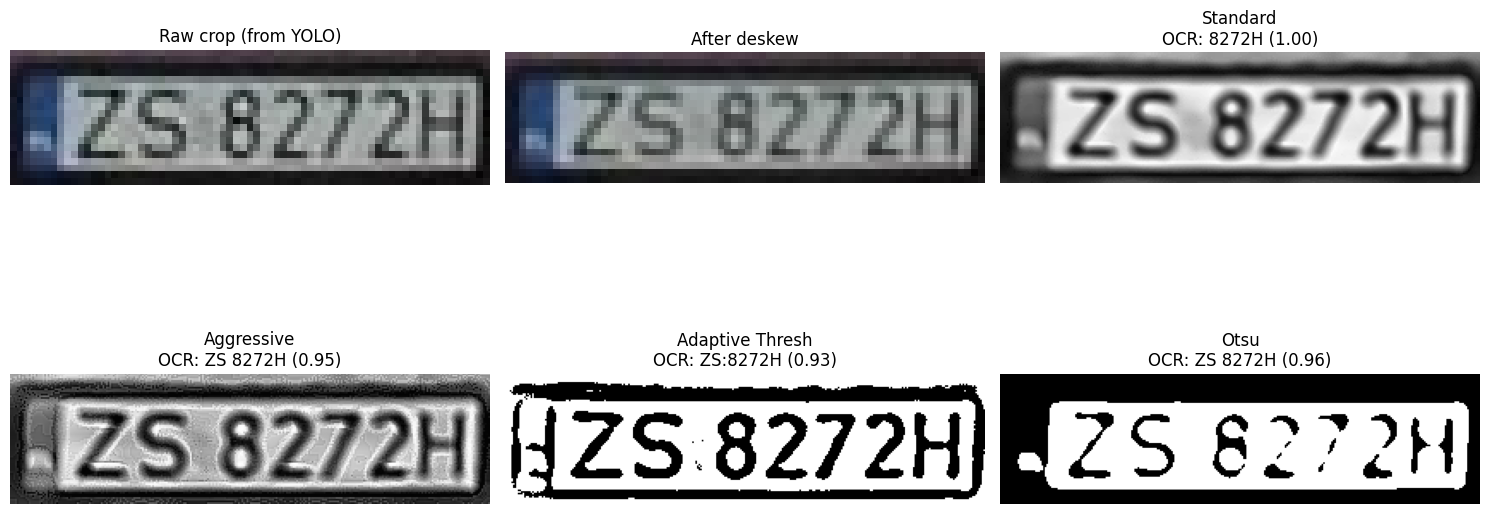


--- OCR Results per variant ---
Standard: ['ZS', '8272H'] | scores: ['0.737', '0.997']
Aggressive: ['ZS 8272H'] | scores: ['0.946']
Adaptive Thresh: ['ZS:8272H'] | scores: ['0.926']
Otsu: ['ZS 8272H'] | scores: ['0.958']


In [96]:
# --- DIAGNOSTYKA: Wizualizacja preprocessingu i porównanie wariantów ---
# Uruchom tę komórkę po detekcji żeby zobaczyć co się dzieje z obrazem

if detections:
    # Weź pierwszy wykryty crop
    det = detections[0]
    crop_raw = det["crop_raw_bgr"]
    crop_deskewed = det["crop_bgr"]
    
    print(f"Raw crop shape: {crop_raw.shape}")
    print(f"Deskewed crop shape: {crop_deskewed.shape}")
    
    # Wygeneruj wszystkie warianty preprocessingu
    variants = preprocess_plate_for_ocr_multi(crop_deskewed)
    variant_names = ["Standard", "Aggressive", "Adaptive Thresh", "Otsu"]
    
    # Wyświetl wszystkie warianty
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    # Raw i deskewed
    axes[0].imshow(cv2.cvtColor(crop_raw, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Raw crop (from YOLO)")
    axes[0].axis('off')
    
    axes[1].imshow(cv2.cvtColor(crop_deskewed, cv2.COLOR_BGR2RGB))
    axes[1].set_title("After deskew")
    axes[1].axis('off')
    
    # Warianty preprocessingu
    for i, (variant, name) in enumerate(zip(variants, variant_names)):
        ax = axes[i + 2]
        ax.imshow(cv2.cvtColor(variant, cv2.COLOR_BGR2RGB))
        
        # Sprawdź OCR na tym wariancie
        try:
            result_list = ocr.predict(variant)
            res = result_list[0].json["res"]
            texts = res.get("rec_texts", [])
            scores = res.get("rec_scores", [])
            if texts:
                idx = max(range(len(texts)), key=lambda j: scores[j] if j < len(scores) else -1)
                ocr_text = f"{texts[idx]} ({scores[idx]:.2f})"
            else:
                ocr_text = "No text"
        except:
            ocr_text = "Error"
        
        ax.set_title(f"{name}\nOCR: {ocr_text}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Pokaż szczegóły
    print("\n--- OCR Results per variant ---")
    for i, (variant, name) in enumerate(zip(variants, variant_names)):
        try:
            result_list = ocr.predict(variant)
            res = result_list[0].json["res"]
            texts = res.get("rec_texts", [])
            scores = res.get("rec_scores", [])
            print(f"{name}: {texts} | scores: {[f'{s:.3f}' for s in scores]}")
        except Exception as e:
            print(f"{name}: Error - {e}")

In [97]:
# --- 3. Processing Results + 4. Cropping + 5. OCR ---
# Collect outputs for optional visualization

detections = []

for box in result.boxes:
    # Get the coordinates (x1, y1, x2, y2)
    coords = box.xyxy[0].cpu().numpy().astype(int)
    x1, y1, x2, y2 = coords

    # Get the confidence of the YOLO detection
    conf = box.conf[0].item()

    print(f"Plate detected at [{x1}, {y1}, {x2}, {y2}] with conf: {conf:.2f}")

    # Crop the license plate from the image (note: slice [y1:y2, x1:x2])
    plate_crop = original_image[y1:y2, x1:x2]

    # Run PaddleOCR on the cropped image
    result_list = ocr.predict(plate_crop)

    # PaddleOCR returns a list of lists. We need to handle cases where it finds nothing.
    res = result_list[0].json["res"]
    texts = res.get("rec_texts", [])
    scores = res.get("rec_scores", [])

    if texts:
        best_i = max(
            range(len(texts)),
            key=lambda i: scores[i] if i < len(scores) else -1,
        )
        best_text = texts[best_i]
        best_score = scores[best_i]
        print(best_text, best_score)
    else:
        best_text = None
        best_score = None
        print("Brak tekstu")

    detections.append(
        {
            "bbox_xyxy": (x1, y1, x2, y2),
            "conf": conf,
            "text": best_text,
            "text_score": best_score,
            "crop_bgr": plate_crop,
        }
    )

len(detections)

Plate detected at [169, 849, 240, 869] with conf: 0.67
ZS8272H 0.9972900748252869
Plate detected at [1149, 584, 1190, 602] with conf: 0.63
Mainin 0.7262497544288635
Plate detected at [518, 847, 579, 866] with conf: 0.62
TST07TJ 0.9873154759407043


3

In [98]:
# --- 3. Processing Results + 4. Cropping + 5. OCR ---
# Collect outputs for optional visualization

detections = []

for box in result.boxes:
    # Get the coordinates (x1, y1, x2, y2)
    coords = box.xyxy[0].cpu().numpy().astype(int)
    x1, y1, x2, y2 = coords

    # Get the confidence of the YOLO detection
    conf = box.conf[0].item()

    print(f"Plate detected at [{x1}, {y1}, {x2}, {y2}] with conf: {conf:.2f}")

    # Crop the license plate from the image (note: slice [y1:y2, x1:x2])
    plate_crop = original_image[y1:y2, x1:x2]

    # Run PaddleOCR on the cropped image
    result_list = ocr.predict(plate_crop)

    # PaddleOCR returns a list of lists. We need to handle cases where it finds nothing.
    res = result_list[0].json["res"]
    texts = res.get("rec_texts", [])
    scores = res.get("rec_scores", [])

    if texts:
        best_i = max(
            range(len(texts)),
            key=lambda i: scores[i] if i < len(scores) else -1,
        )
        best_text = texts[best_i]
        best_score = scores[best_i]
        print(best_text, best_score)
    else:
        best_text = None
        best_score = None
        print("Brak tekstu")

    detections.append(
        {
            "bbox_xyxy": (x1, y1, x2, y2),
            "conf": conf,
            "text": best_text,
            "text_score": best_score,
            "crop_bgr": plate_crop,
        }
    )

len(detections)

Plate detected at [169, 849, 240, 869] with conf: 0.67
ZS8272H 0.9972900748252869
Plate detected at [1149, 584, 1190, 602] with conf: 0.63
Mainin 0.7262497544288635
Plate detected at [518, 847, 579, 866] with conf: 0.62
TST07TJ 0.9873154759407043


3

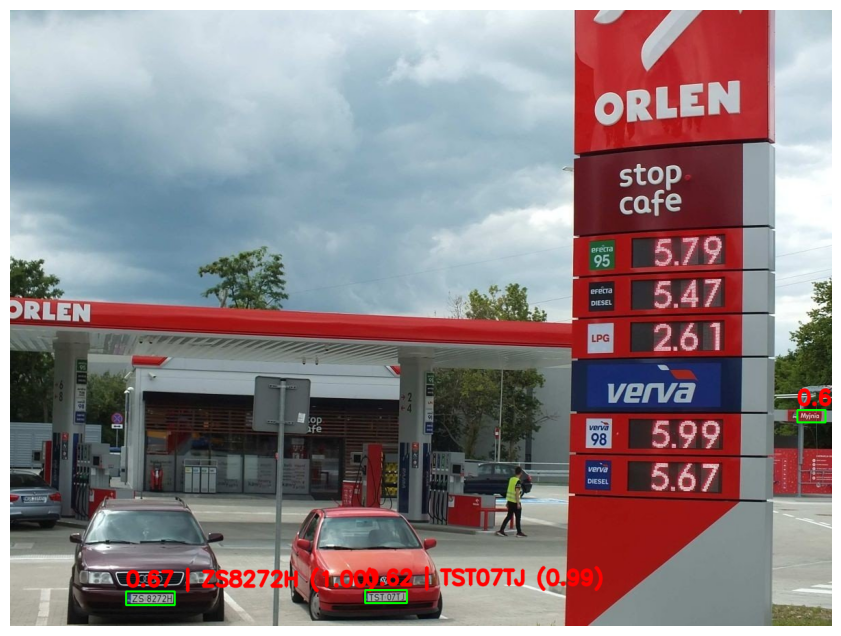

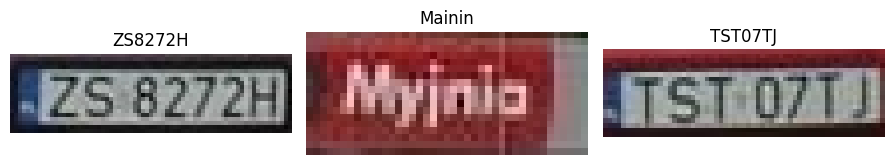

In [99]:
# Optional: visualize detections + crops

img_vis = original_image.copy()

for d in detections:
    x1, y1, x2, y2 = d["bbox_xyxy"]
    label = f"{d['conf']:.2f}"
    if d["text"]:
        label += f" | {d['text']} ({(d['text_score'] or 0):.2f})"

    cv2.rectangle(img_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(
        img_vis,
        label,
        (x1, max(0, y1 - 8)),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 0, 255),
        3,
        cv2.LINE_AA,
    )

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

if detections:
    n = len(detections)
    plt.figure(figsize=(4 * min(n, 4), 4 * ((n + 3) // 4)))
    for i, d in enumerate(detections, start=1):
        plt.subplot(((n + 3) // 4), 4, i)
        plt.imshow(cv2.cvtColor(d["crop_bgr"], cv2.COLOR_BGR2RGB))
        title = d["text"] if d["text"] else "(no text)"
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()